# Прогнозирование стоимости автомобиля по его характеристикам
# Часть 1: обработка данных и EDA

### Название команды на Kaggle - "Good Team"

*Над проектом работали: Бочкарева Ксения (bochkareva.2014@mail.ru), Журавлев Алексей (alexeizhuravlev@icloud.com)*

**Цель**: Обучить лучшую модель для предсказания цен на автомобили.

**Задачи**:
1. Собрать тренировочный датасет (парсинг данных)
2. Сравнить собранный датасет с тем датасетом, что предоставлен в качестве тестового
3. Почистить данные, отобрать (и сгенирировать при необходимости) нужные признаки
4. Провести разведываетльный анализ данных (+ визуализация)
5. Экспериментальным путем выявить какой алгоритм справляется с задачей предсказания цен лучше всего
6. Попробовать объеденить несколько алгоритмов для улучшения предсказаний (стэкинг), сделать выводы
7. Сделать submission на Kaggle и зафиксировать результат
8. Отформатировать код и выложить на GitHub 

**Описание датасета**:

Данные представляют из себя набор характеристик автомобилей, выставленных на продажу: тип кузова, дата выпуска модели, объем двиагателя и т.д. Целевая переменная - *price* - цена автомобиля. 
* Данные для тренировочногодатасета были спарсены с сайта Auto.ru. Всего в собранном тренировочном датасете 100974 наблюдений (до фильтрации). Таким образом, задача предсказания цены автомобиля сводится в целом к задаче *регрессии*. 
* В тестовом датасете 34686 наблюдений - объявлений о продаже машин. Для каждого из них нужно предсказать цену автомобиля по его характеристикам.

## Подготовка к началу работы

In [1]:
from sklearn.ensemble import BaggingRegressor, StackingRegressor
import warnings
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from datetime import timedelta, datetime, date
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from prettytable import PrettyTable
from pandas import Series
from sklearn.feature_selection import f_regression, mutual_info_regression
import xgboost as xgb
from prettytable import PrettyTable

import seaborn as sns
%matplotlib inline


warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

!pip freeze > requirements.txt

Python       : 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.18.5


## Описание датасетов: соответствие тренировочного и тестового

**Подгружаем необходимые данные**

Ноутбук с кодом парсинга тренировочной базы, а также с преобразованиями тестовой будет предоставлен отдельно.

In [2]:
# тестовый датасет, отсюда возьмем в конце sell_id
data_kaggle = pd.read_csv('test_module5.csv')
sample_submission = pd.read_csv(
    'sample_submission_module5.csv')  # шаблон сабмита на Kaggle

In [20]:
# спарсенный тренировочный датасет
data_train = pd.read_csv('main_auto_df.csv')

In [4]:
# переделанный тестовый датасет
data_test_upgraded = pd.read_csv('df_test.csv')

In [5]:
# тестовый датасет, в котором раздел "комплектация" скачан по car_url, тем же парсером, что тренинговая дата
test_data = pd.read_csv('my_car.csv')

In [6]:
# В data_test_upgraded заменим "комплектация" на "комплектация" из test_data
data_test_upgraded['комплектация'] = test_data['комплектация']

### **Предобработка тестового датасета**

Сначала поработаем с преобразованным тестовым датасетом, а затем будем переделывать тренировочный по его подобию.

In [10]:
data_test_upgraded.sample(2)  # изначальный вид датасета

,Unnamed: 0,год выпуска,Пробег,Кузов,Цвет,Объем,Мощность,Топливо,Коробка,Привод,Руль,Владельцы,ПТС,Таможня,model,комплектация
584,584,8,91000,внедорожник 5 дв.,красный,1.2,105.0,бензин,роботизированная,передний,Левый,1 владелец,Оригинал,Растаможен,SKODA,"['Рейлинги на крыше', 'Стальные диски', 'Центр..."
20020,20020,26,220000,седан,зелёный,3.0,230.0,бензин,автоматическая,задний,Правый,3 или более,Дубликат,Растаможен,TOYOTA,20020


In [11]:
# удалим ненужные переменные
data_test_upgraded.drop(['Unnamed: 0', 'Таможня'], axis=1, inplace=True)

# поменяем название колонки на корректное
data_test_upgraded.rename(
    columns={'год выпуска': 'Возраст', 'model': 'Модель'}, inplace=True)

# заполним один пропуск самым частым значением
data_test_upgraded['ПТС'].fillna('Оригинал', axis=0, inplace=True)

# посчитаем количество фич, которые указаны в описании комплектации машины
# если в признаке не строка, а число, значит информации о комплектации нет, количество фич = 0

data_test_upgraded['#комплектации'] = data_test_upgraded['комплектация'].\
    apply(lambda x: len(x[1:-1].split(',')) if type(x == str) else 0)

# удалим изначальную переменную
data_test_upgraded.drop('комплектация', axis=1, inplace=True)

# отберем тип кузова, который есть ТОЛЬКО в тестовой выборке + один самый малочисленный, причислим это к категории Другое,
# чтобы категории кузова совпадали в трейне и тесте
# таким образом почти все (кроме одной) пересекающиеся категории останутся, но и в трейне, и в тесте будет категория Другое

kuzov_list = ['седан 2 дв.', 'пикап полуторная кабина', 'внедорожник открытый',
              'фастбек', 'седан-хардтоп', 'лимузин', 'пикап одинарная кабина']

data_test_upgraded['Кузов'] = np.where(data_test_upgraded['Кузов'].isin(
    kuzov_list), 'Другой', data_test_upgraded['Кузов'])

Посмотрим на датасет:

In [13]:
data_test_upgraded.head(2)  # все хорошо

,Возраст,Пробег,Кузов,Цвет,Объем,Мощность,Топливо,Коробка,Привод,Руль,Владельцы,ПТС,Модель,#комплектации
0,7,74000,лифтбек,синий,1.2,105.0,бензин,роботизированная,передний,Левый,3 или более,Оригинал,SKODA,36
1,4,60563,лифтбек,чёрный,1.6,110.0,бензин,механическая,передний,Левый,1 владелец,Оригинал,SKODA,35


### **Предобработка тренировочного датасета**

Преобразуем названия и значения переменных в соответствии и тестовой базой.

In [21]:
# удалим ненужные переменные
# причины: неинформативность / константа / нет аналога в тестовой базе
data_train.drop(['Unnamed: 0', 'Таможня', 'Налог',
                 'Состояние', 'Владение', 'Таможня',
                 'Гарантия', 'VIN', 'Госномер', 'Обмен',
                 'Кузов №', 'Запас хода', 'Статус'], axis=1, inplace=True)

# поменяем название колонки на корректное
data_train.rename(columns={'model': 'Модель', 'price': 'Цена'}, inplace=True)

**Поработаем с преобразованием значений переменных**

In [24]:
# + означает, что в тесте и трейне переменные имеют идентичную структуру

# доделываем историю про кузов +
data_train['Кузов'] = np.where(data_train['Кузов'].isin(
    kuzov_list), 'Другой', data_train['Кузов'])

# посчитаем количество фич, которые указаны в описании комплектации машины  +
data_train['#комплектации'] = data_train['комплектация'].apply(
    lambda x: len(x.split(',')))

# единицы означают, что изначально там был 0 или "нет информации" - заменим на 0, т.е. никаких фич не указано
data_train['#комплектации'] = np.where(
    data_train['#комплектации'] == 1, 0, data_train['#комплектации'])

# удалим изначальную переменную
data_train.drop('комплектация', axis=1, inplace=True)

In [27]:
# возраст машины +
data_train['Возраст'] = data_train['год выпуска'].apply(lambda x: 2021 - x)
data_train.drop('год выпуска', axis=1, inplace=True)

# убираем км из Пробега +
data_train['Пробег'] = data_train['Пробег'].str.extract(
    '(\d+)', expand=False).astype('float')

# в тренировочной выборке есть розовый цвет, а
# в тествой - нет, поэтому заменим самый редкий цвет на единую категорию +
data_train['Цвет'] = np.where(
    data_train['Цвет'] == 'золотистый', 'другой', data_train['Цвет'])
data_test_upgraded['Цвет'] = np.where(
    data_test_upgraded['Цвет'] == 'розовый', 'другой', data_test_upgraded['Цвет'])

In [28]:
# из переменной Двигатель вычленим три показателя: Объем, Мощность и Топливо +
data_train['Двигатель'] = data_train['Двигатель'].apply(
    lambda x: x.split('/ '))

data_train['Объем'] = 0
data_train['Мощность'] = 0
data_train['Топливо'] = 0


try:
    for i in range(len(data_train['Двигатель'])):
        if 'Электро' in data_train['Двигатель'].iloc[i][2]:
            # если авто на электричестве - объем двигателя нулевой
            data_train['Объем'].iloc[i] = 0.0
        else:
            data_train['Объем'].iloc[i] = float(
                data_train['Двигатель'].iloc[i][0][:3])
        data_train['Мощность'].iloc[i] = float(
            data_train['Двигатель'].iloc[i][1][:-5])
        data_train['Топливо'].iloc[i] = data_train['Двигатель'].iloc[i][2]
except Exception as ex:
    print(data_train['Двигатель'].iloc[i], i, ex)


# унифицируем категории в трейне и тесте
data_train['Топливо'] = data_train['Топливо'].str.lower()
data_train['Топливо'] = np.where(data_train['Топливо'] == 'бензин, газобаллонное оборудование',
                                                          'газ', data_train['Топливо'])

# удалим старую переменную
data_train.drop('Двигатель', axis=1, inplace=True)

In [29]:
# унифицируем категории в трейне и тесте +
data_train['Владельцы'] = np.where(data_train['Владельцы'] == '1владелец', '1\xa0владелец',
                                   np.where(data_train['Владельцы'] == '2владельца', '2\xa0владельца', data_train['Владельцы']))

# унифицируем категории
data_train['Модель'] = data_train['Модель'].str.upper()
data_train['Модель'] = np.where(
    data_train['Модель'] == 'MERCEDES-BENZ', 'MERCEDES', data_train['Модель'])

# В тесте намного меньше марок, чем в трейне:
# самую редкую марку в трейне и все непересекающиеся марки в трейне превратим в "Другое" (возможно удалим признак потом) +

car_list = ['BMW', 'VOLKSWAGEN', 'NISSAN', 'MERCEDES', 'TOYOTA',
            'AUDI', 'MITSUBISHI', 'SKODA', 'VOLVO', 'HONDA', 'INFINITI']

data_train['Модель'] = np.where(data_train['Модель'].isin(
    car_list), data_train['Модель'], 'Другое')
data_test_upgraded['Модель'] = np.where(data_test_upgraded['Модель'].isin(
    car_list), data_test_upgraded['Модель'], 'Другое')

In [30]:
data_train.head(2)  # все хорошо

,Пробег,Кузов,Цвет,Коробка,Привод,Руль,Владельцы,ПТС,Модель,Цена,#комплектации,Возраст,Объем,Мощность,Топливо
0,62000.0,хэтчбек 5 дв.,синий,механическая,передний,Левый,2 владельца,Оригинал,Другое,820000.0,25,5,1.6,130.0,бензин
1,135835.0,седан,чёрный,роботизированная,передний,Левый,3 или более,Оригинал,AUDI,795000.0,0,8,1.4,122.0,бензин


**Проверяем пропущенные значения**

In [31]:
# посмотрим на количество пропусков
missings = pd.DataFrame(data_train.isna().sum()).reset_index()
missings.rename(columns={'index': 'Переменная', 0: 'Кол-во NA'}, inplace=True)
missings

,Переменная,Кол-во NA
0,Пробег,0
1,Кузов,0
2,Цвет,0
3,Коробка,0
4,Привод,0
5,Руль,0
6,Владельцы,0
7,ПТС,0
8,Модель,0
9,Цена,3434


Видим, что в целевой переменной есть пропуски - удалим эти наблюдения:

In [32]:
data_train.dropna(axis=0, inplace=True)

Заранее сделаем **логарифмирование целевой переменной** - именно логарифм цены и будем предсказывать, так как логарифмирование делает распрделение более нормальным, что потенциально влияет на качество предсказаний регрессии.

In [33]:
# возьмем натуральный логарифм от цены
data_train['Лог_Цена'] = np.log(data_train['Цена'])

Теперь оба датасета готовы к дальнейшей работе!

### **Объединение и разметка**

In [34]:
data_train['sample'] = 1  # трейн
data_test_upgraded['sample'] = 0  # тест

# в тесте у нас нет значения Цены, мы его должны предсказать, поэтому пока просто заполняем nan
data_test_upgraded['Лог_Цена'] = np.nan
data_test_upgraded['Цена'] = np.nan

# соединяем датасеты
data = data_test_upgraded.append(data_train, sort=False).reset_index(drop=True)

Посмотрим на общий датасет, с которым в дальнейшем будем работать:

In [35]:
print('Размерность финального датасета:', data.shape)
data.head(3)

Размерность финального датасета: (132226, 17)


,Возраст,Пробег,Кузов,Цвет,Объем,Мощность,Топливо,Коробка,Привод,Руль,Владельцы,ПТС,Модель,#комплектации,sample,Лог_Цена,Цена
0,7,74000.0,лифтбек,синий,1.2,105.0,бензин,роботизированная,передний,Левый,3 или более,Оригинал,SKODA,36,0,NaN,NaN
1,4,60563.0,лифтбек,чёрный,1.6,110.0,бензин,механическая,передний,Левый,1 владелец,Оригинал,SKODA,35,0,NaN,NaN
2,7,88000.0,лифтбек,серый,1.8,152.0,бензин,роботизированная,передний,Левый,1 владелец,Оригинал,SKODA,52,0,NaN,NaN


## Эксплораторный анализ данных

В наших данных присутствуют переменные разного типа. Для большей структурированность эксплораторного анализа формально распределим предикторы по типу данных: *количественные и категориальные*. 

In [37]:
cat_cols = ['Цвет', 'Топливо', 'Коробка', 'Привод',
            'Руль', 'Владельцы', 'ПТС', 'Модель', 'Кузов']

num_cols = ['Возраст', 'Пробег', 'Объем', 'Мощность', '#комплектации']

Введем несколько функций для визуализации и статистики:

In [38]:
# визуализация для количественных переменных - код заимствован у Natalia Melnik - очень понравилась идея визуализации

def visual(col, size=6):
    fig, (g1, g2) = plt.subplots(1, 2, figsize=(2*size, size))
    fig.suptitle('Histogram and boxplot for {0} '.format(col), fontsize=18)

    g1.hist(data[col], bins=20, histtype='bar', align='mid',
            rwidth=0.8, color='green')  # гистограмма

    # боксплот для того, чтобы посмотреть выбросы
    g2.boxplot(data[col], vert=False)
    plt.figtext(0.5, 0, col, fontsize=16)
    plt.show

In [39]:
# для получения статистик

def stats(col):
    stats = pd.DataFrame(data[col].describe()).T
    stats = round(stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max']], 2)
    stats = stats.rename(columns={'50%': 'median'})
    return stats

In [40]:
# для визуализации диаграмм рассеивания

def scatter(col, n):
    sns.set(style="white")
    plt.figure(figsize=(9, 5))
    plt.title('Зависимость между ценой авто и переменной ' + col, fontsize=18)
    # ограничиваем диапазоп значений предиктора для улучшения визуализации (если нужно)
    data1 = data[data[col] < n]
    sns.regplot(col, "Лог_Цена", data=data1,
                scatter_kws={'s': 25, "alpha": 0.5})

In [41]:
# для визуализации взаимосвязи категориальных предикторов и количественной таргет переменной

def box(col):
    sns.set(style="white")
    plt.figure(figsize=(9, 5))
    plt.title('Взаимосвязь цены и переменной ' + col, fontsize=18)
    sns.boxplot(x="Лог_Цена", y=col, data=data, palette='rainbow')

## 1. Исследование целевой переменной: цена автомобиля

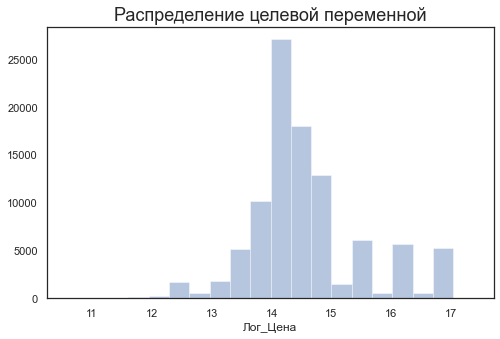

In [42]:
sns.set(style="white")
plt.figure(figsize=(8, 5))
plt.title('Распределение целевой переменной', fontsize=18)

sns.distplot(data['Лог_Цена'], kde=False, bins=20)

* Видим, что после логарифмирования целевая переменная приняла относительно нормальное распределение. 
* Средняя цена автомобиля около 3.5 миллионов рублей, а медианная - около 1.8 миллионов.
* Большинство автомобилей стоят от 1.2 до 2.7 миллионов рублей.

## 2. Исследование количественных переменных

Замечание: мы понимаем, что в количественных переменных есть выбросы, однако намеренно их не удаляем, потому что в тестовой выборке много выбросов, и наша финальная модель должна уметь делать адекватные предсказания и на таких данных.

### **Возраст автомобиля**

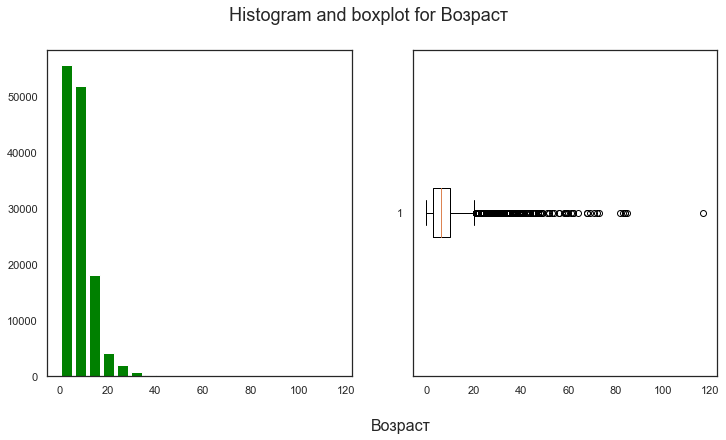

In [43]:
visual('Возраст')

In [587]:
stats('Возраст')

,mean,std,min,25%,median,75%,max
Возраст,7.65,5.85,0.0,3.0,6.0,10.0,117.0


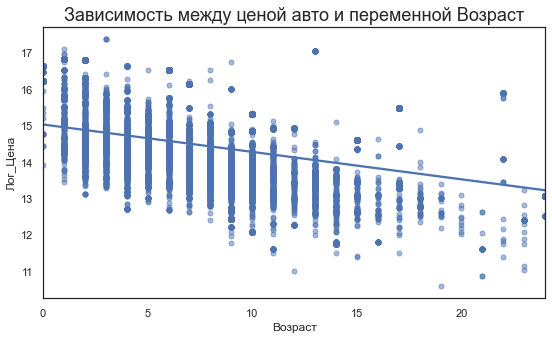

In [588]:
scatter('Возраст', 25)

* Большинство автомобилей в нашей выборке имеют возраст от 3 до 10 лет.
* Средний возраст автомобиля - примерно 7.5 лет.
* Зависимость между возрастом автомобиля и ценой, как и ожидалось, обратная: чем старше автомобиль, тем он дешевле.

### **Пробег**

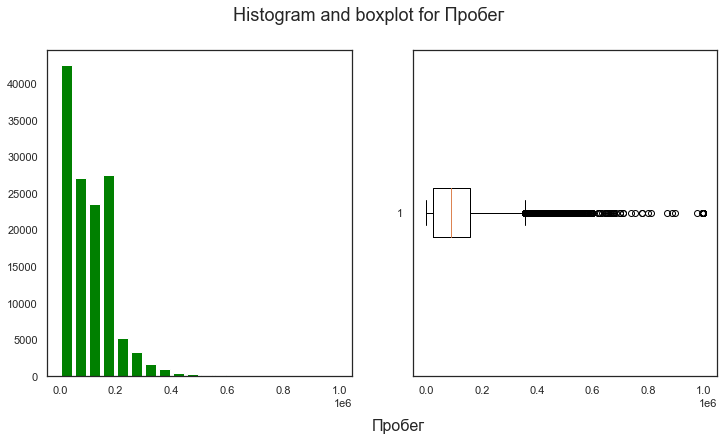

In [589]:
visual('Пробег')

In [590]:
stats('Пробег')

,mean,std,min,25%,median,75%,max
Пробег,103044.9,84207.84,1.0,23761.0,90312.0,156966.0,1000000.0


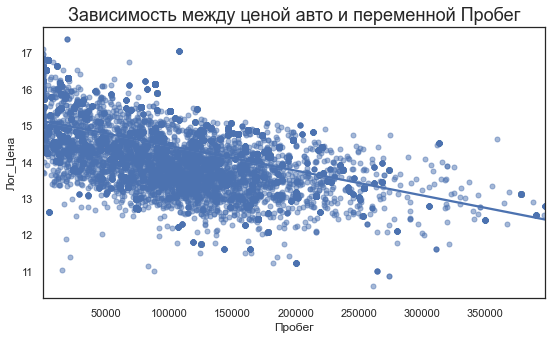

In [591]:
scatter('Пробег', 400000)

* Большинство автомобилей имеют пробег от 20 до 160 км, средний пробег - приблизительно 100 км.
* Зависимость между пробегом и ценой автомобиля, как и ожидалось, обратная: чем больше пробег, тем ниже цена на авто.

### **Объем двигателя**

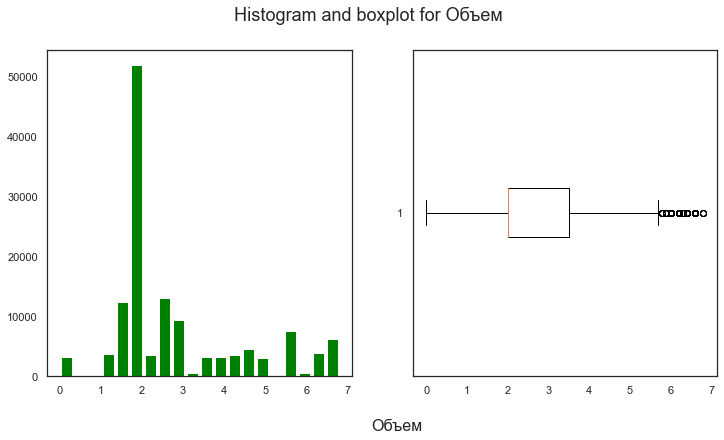

In [592]:
visual('Объем')

In [593]:
stats('Объем')

,mean,std,min,25%,median,75%,max
Объем,2.85,1.58,0.0,2.0,2.0,3.5,6.8


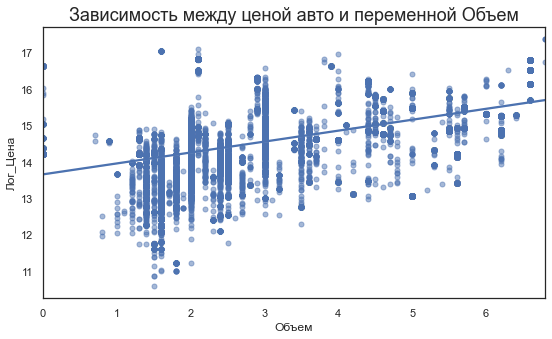

In [594]:
scatter('Объем', 7)

* Большинство автомобилей имеют объем от 2 до 3.5 л., средний объем - 2.8 л.
* Наблюдаем прямую зависимость между объемом двигателя и ценой автомобиля: чем больше объем, тем, в среднем, выше цена.

### **Мощность двигателя**

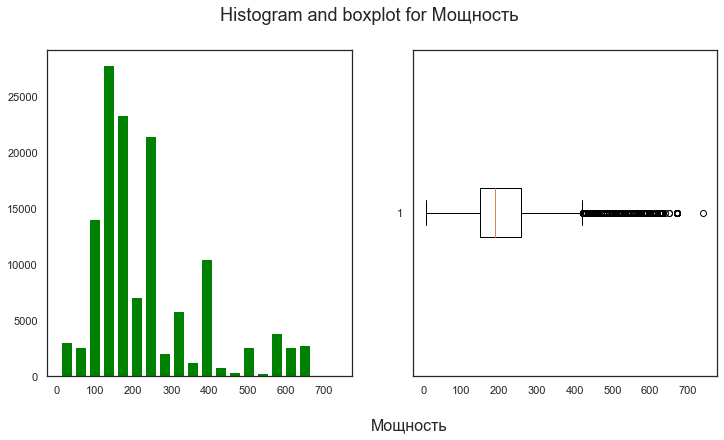

In [595]:
visual('Мощность')

In [596]:
stats('Мощность')

,mean,std,min,25%,median,75%,max
Мощность,235.82,141.29,8.0,150.0,190.0,258.0,740.0


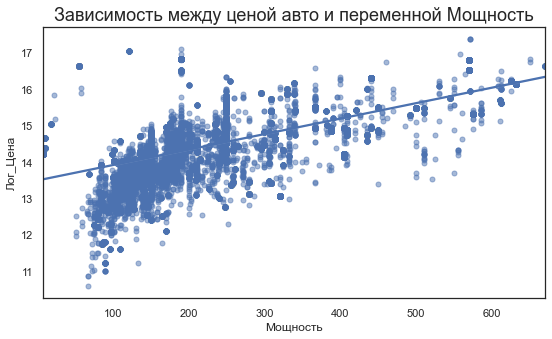

In [597]:
scatter('Мощность', 700)

* Большинство автомобилей имеют мощность двигателя от 150 до 300 л.с., средняя мощность - 235, а медианная - 190.
* Наблюдаем прямую зависимость между мощностью двигателя и ценой на авто: чем мощнее двигатель, тем, в среднем, выше цена.

### Количество фич в комплектации

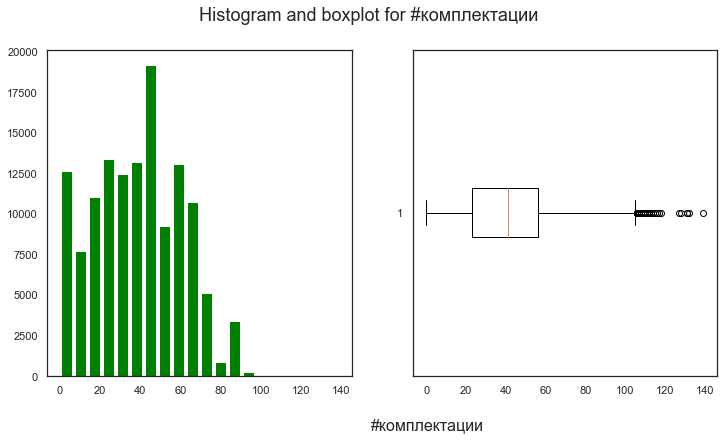

In [44]:
visual('#комплектации')

In [45]:
stats('#комплектации')

,mean,std,min,25%,median,75%,max
#комплектации,38.35,21.78,0.0,23.0,41.0,56.0,139.0


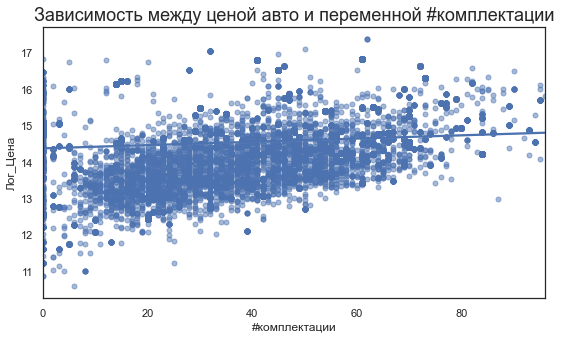

In [47]:
scatter('#комплектации', 100)

* В описании некоторых моделей отсутствует комплектация - мы обозначили это за 0.
* Большинство машин имеют от 20 до 60 фич в описании комплектации.
* Взаимосвязь довольно слабая, но наша изначальная гипотеза была в том, что с увеличением количества фич в комплектации цена возрастает.

**Стандартизуем непрерывные переменные:**

In [48]:
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

**Корреляционный анализ**:

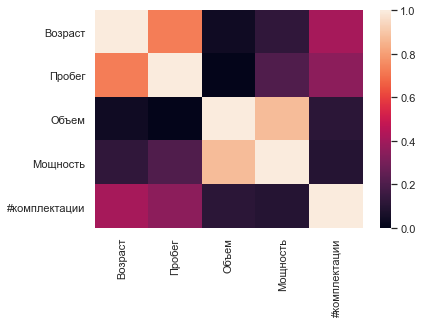

In [49]:
gg = sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)
gg.figure.set_size_inches(6, 4)

* Видим, что объем и мощность двигателя сильно скоррелированы, что вполне ожидаемо. Удалим объем двигателя.
* Пробег и возраст автомобиля тоже довольно сильно коррелируют, но пока оставим оба предиктора.

In [50]:
data.drop('Объем', axis=1, inplace=True)
num_cols.remove('Объем')

**Значимость непрерывных переменных**

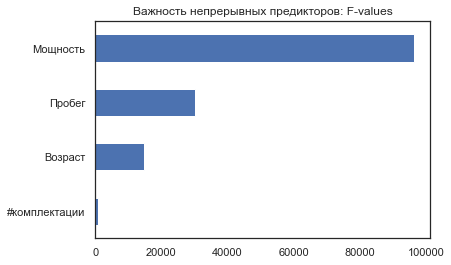

In [51]:
# важность непрерывных признаков только на тренировочной выборке,
# поскольку на тестовой реальных значений целевой переменной нет

imp_num = Series(f_regression(data[data['sample'] == 1][num_cols],
                              data[data['sample'] == 1]['Лог_Цена'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', title='Важность непрерывных предикторов: F-values')

* Мощность двигателя вносит наибольший вклад в объяснение целевой переменной, а вот количество фич в комплектации - совсем малый.

## 2. Исследование категориальный переменных

### **Цвет автомобиля**

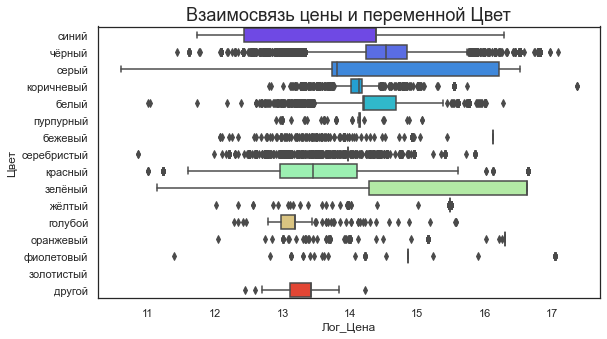

In [605]:
box('Цвет')

* Сложно проследить четкую взаимосвязь между ценой и цветом автомобиля.
* Черные автомобили чаще всего оказываются самыми дорогими.

### Тип кузова

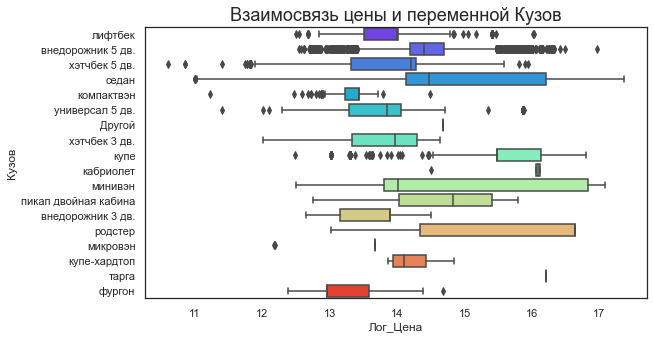

In [606]:
box('Кузов')

* Сложно отследить четкую зависимость между ценой и типом кузова.

### **Вид топлива**

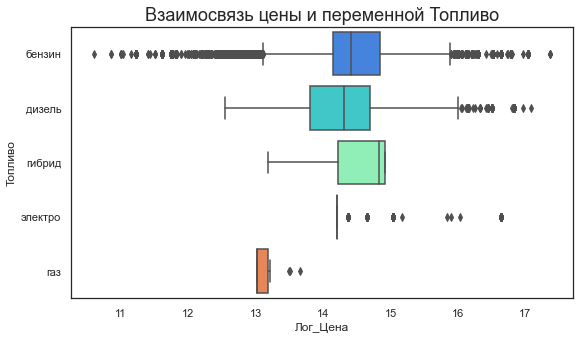

In [607]:
box('Топливо')

* Взаимосвязь цены и типа топлива также сложно отследить. Довольно много выбросов.
* Автомобили на гибридном топливе, в среднем, стоят дороже.

### **Тип коробки передач**

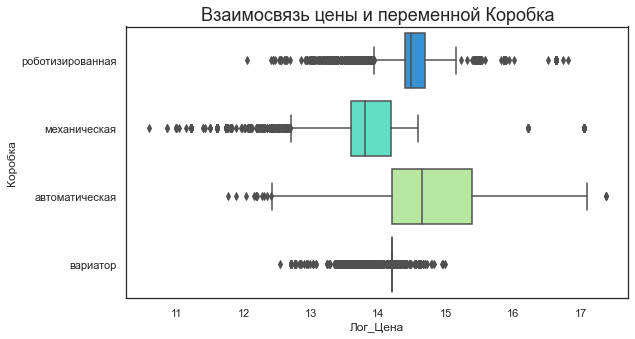

In [608]:
box('Коробка')

* Автомобили с автоматической коробкой передач в среднем стоят дороже, а с механической - дешевле.

### **Тип привода**

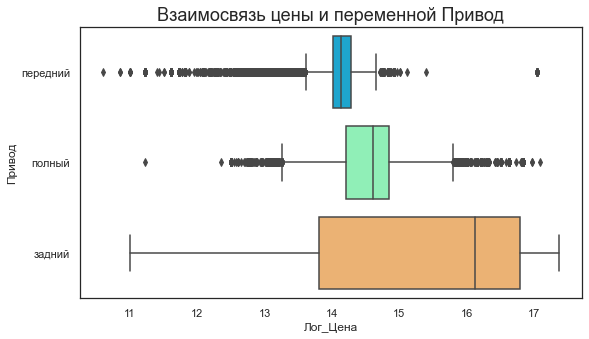

In [609]:
box('Привод')

* Автомобили с задним приводом в среднем стоят дороже, а с передним - дешевле.

### **Положение руля**

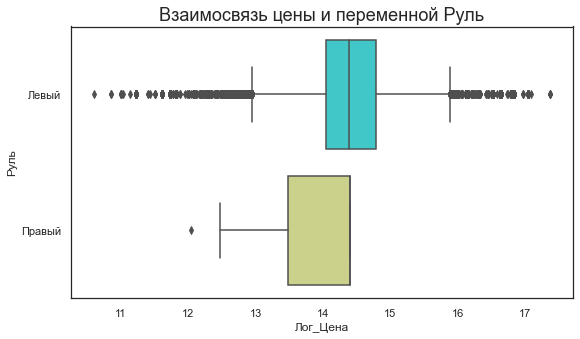

In [610]:
box('Руль')

* Автомобили, в которых руль находится слева - в среднем дороже, но альтернативный вариант представлен в выборке очень мало, поэтому нельзя сделать точного вывода.

### **Количество владельцев**

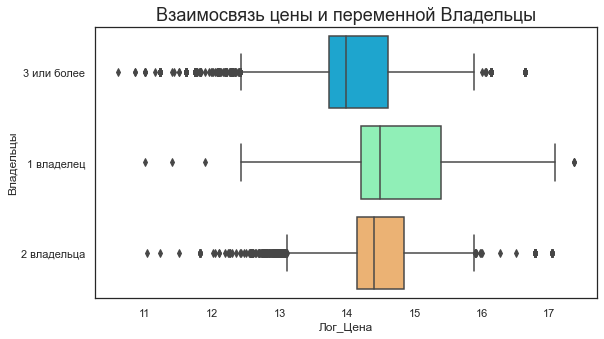

In [611]:
box('Владельцы')

* Машины с 1 владельцем стоят в среднем немного дороже, чем авто с большим количеством владельцев.

### **Паспорт транспортного средства**

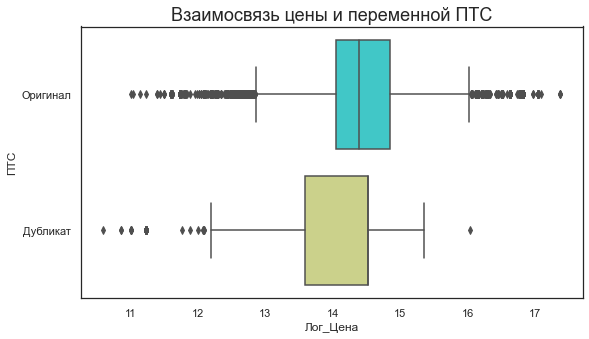

In [612]:
box('ПТС')

* Машины с оригинальным ПТС в среднем стоят дороже, но опять же, альтернативный вариант очень плохо представлен в выборке, поэтому нельзя точно сказать.

### **Марка автомобиля**

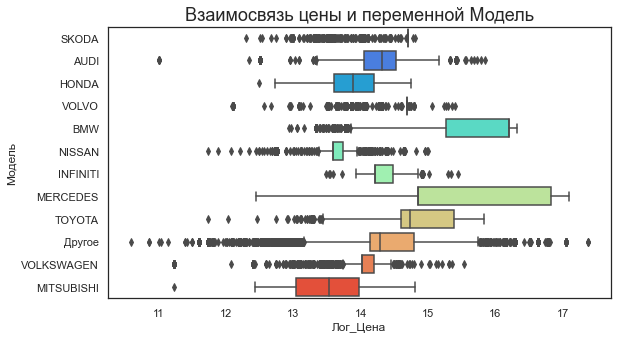

In [613]:
box('Модель')

* Видим, что MERCEDES и BMW, в среднем, самые дорогие марки.

**Перекодируем все категориальные переменные в dummy**:

In [52]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

Посмотрим на датасет:

In [53]:
data.head(3)  # все хорошо

,Возраст,Пробег,Мощность,#комплектации,sample,Лог_Цена,Цена,Цвет_бежевый,Цвет_белый,Цвет_голубой,Цвет_другой,Цвет_жёлтый,Цвет_зелёный,Цвет_золотистый,Цвет_коричневый,Цвет_красный,Цвет_оранжевый,Цвет_пурпурный,Цвет_серебристый,Цвет_серый,Цвет_синий,Цвет_фиолетовый,Цвет_чёрный,Топливо_бензин,Топливо_газ,Топливо_гибрид,Топливо_дизель,Топливо_электро,Коробка_автоматическая,Коробка_вариатор,Коробка_механическая,Коробка_роботизированная,Привод_задний,Привод_передний,Привод_полный,Руль_Левый,Руль_Правый,Владельцы_1 владелец,Владельцы_2 владельца,Владельцы_3 или более,ПТС_Дубликат,ПТС_Оригинал,Модель_AUDI,Модель_BMW,Модель_HONDA,Модель_INFINITI,Модель_MERCEDES,Модель_MITSUBISHI,Модель_NISSAN,Модель_SKODA,Модель_TOYOTA,Модель_VOLKSWAGEN,Модель_VOLVO,Модель_Другое,Кузов_Другой,Кузов_внедорожник 3 дв.,Кузов_внедорожник 5 дв.,Кузов_кабриолет,Кузов_компактвэн,Кузов_купе,Кузов_купе-хардтоп,Кузов_лифтбек,Кузов_микровэн,Кузов_минивэн,Кузов_пикап двойная кабина,Кузов_родстер,Кузов_седан,Кузов_тарга,Кузов_универсал 5 дв.,Кузов_фургон,Кузов_хэтчбек 3 дв.,Кузов_хэтчбек 5 дв.
0,-0.110703,-0.344921,-0.925926,-0.108000,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,-0.623694,-0.504491,-0.890536,-0.153918,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,-0.110703,-0.178665,-0.593266,0.626681,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [54]:
# data.to_csv('final_data_module5.csv') - финальный датасет, который используется для построения моделей во второй части